In [13]:
import warnings
warnings.filterwarnings("ignore")
from scipy.linalg import svd
from colorama import init, Fore, Back, Style
import pandas as pd
import numpy as np
import seaborn as sns
import re
import shap
from dash import dcc, html, dash_table, Input, Output
import dash_bootstrap_components as dbc
import dash
from dash_extensions import EventListener
import dash_core_components as dcc
import dash_html_components as html
import dash_table
from dash.dependencies import Input, Output
from collections import Counter
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from scipy.stats import kurtosis, skew, iqr, probplot
from statsmodels.robust import mad
import ipywidgets as widgets
from IPython.display import display, clear_output
from scipy.stats import shapiro, kstest, anderson
import plotly.express as px
import plotly.graph_objects as go
import scipy.stats as stats
import glob

from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler, LabelEncoder, KBinsDiscretizer, OneHotEncoder
from sklearn.linear_model import Lasso
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.decomposition import PCA
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor


### Data Collection

In [14]:
dnames = ["train_FD001","test_FD001","RUL_FD001"]
rnames = ["train","test","RUL"]
for i,dname in enumerate(dnames):
    read_files = glob.glob(f"/Users/aswathshakthi/PycharmProjects/MLOps/Predictive_maintenance/data/raw/{dname}.txt")
    with open(f"/Users/aswathshakthi/PycharmProjects/MLOps/Predictive_maintenance/data/interim/{rnames[i]}.txt", "wb") as outfile:
        for f in read_files:
            with open(f, "rb") as infile:
                outfile.write(infile.read())
            


In [15]:
# Give names to the features
index_names = ['engine', 'cycle']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names=[ "(Fan inlet temperature) (◦R)","(LPC outlet temperature) (◦R)",
               "(HPC outlet temperature) (◦R)","(LPT outlet temperature) (◦R)",
               "(Fan inlet Pressure) (psia)", "(bypass-duct pressure) (psia)",
               "(HPC outlet pressure) (psia)", "(Physical fan speed) (rpm)",
               "(Physical core speed) (rpm)", "(Engine pressure ratio(P50/P2)",
               "(HPC outlet Static pressure) (psia)","(Ratio of fuel flow to Ps30) (pps/psia)",
               "(Corrected fan speed) (rpm)","(Corrected core speed) (rpm)",
               "(Bypass Ratio) ","(Burner fuel-air ratio)",
               "(Bleed Enthalpy)","(Required fan speed)",
               "(Required fan conversion speed)","(High-pressure turbines Cool air flow)","(Low-pressure turbines Cool air flow)" ]
col_names = index_names + setting_names + sensor_names

df_train = pd.read_csv(('/Users/aswathshakthi/PycharmProjects/MLOps/Predictive_maintenance/data/interim/train.txt'), sep='\s+', header=None, names=col_names)
df_test = pd.read_csv(('/Users/aswathshakthi/PycharmProjects/MLOps/Predictive_maintenance/data/interim/test.txt'), sep='\s+', header=None, names=col_names)
df_test_RUL = pd.read_csv(('/Users/aswathshakthi/PycharmProjects/MLOps/Predictive_maintenance/data/interim/RUL.txt'), sep='\s+', header=None, names=['RUL'])

In [16]:
df_train

,engine,cycle,setting_1,setting_2,setting_3,(Fan inlet temperature) (◦R),(LPC outlet temperature) (◦R),(HPC outlet temperature) (◦R),(LPT outlet temperature) (◦R),(Fan inlet Pressure) (psia),...,(Ratio of fuel flow to Ps30) (pps/psia),(Corrected fan speed) (rpm),(Corrected core speed) (rpm),(Bypass Ratio),(Burner fuel-air ratio),(Bleed Enthalpy),(Required fan speed),(Required fan conversion speed),(High-pressure turbines Cool air flow),(Low-pressure turbines Cool air flow)
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,519.49,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,519.68,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,520.01,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,519.67,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640


In [17]:
df_test_RUL

,RUL
0,112
1,98
2,69
3,82
4,91
...,...
95,137
96,82
97,59
98,117


In [18]:
df_train_RUL = df_train.groupby(['engine']).agg({'cycle':'max'})
df_train_RUL.rename(columns={'cycle':'life'},inplace=True)
df_train_RUL.head()

,life
engine,
1,192
2,287
3,179
4,189
5,269


In [19]:
df_train = df_train.merge(df_train_RUL,on='engine',how='left')

In [20]:
df_train['RUL']=df_train['life']-df_train['cycle']
df_train.drop(['life'],axis=1,inplace=True)
df_train

,engine,cycle,setting_1,setting_2,setting_3,(Fan inlet temperature) (◦R),(LPC outlet temperature) (◦R),(HPC outlet temperature) (◦R),(LPT outlet temperature) (◦R),(Fan inlet Pressure) (psia),...,(Corrected fan speed) (rpm),(Corrected core speed) (rpm),(Bypass Ratio),(Burner fuel-air ratio),(Bleed Enthalpy),(Required fan speed),(Required fan conversion speed),(High-pressure turbines Cool air flow),(Low-pressure turbines Cool air flow),RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735,4
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594,3
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333,2
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640,1


In [21]:
df_test_RUL.columns = ['RUL']
df_test_RUL['engine'] = range(1, len(df_test_RUL) + 1)
df_test = df_test.merge(df_test_RUL,on='engine',how='left')
df_test

,engine,cycle,setting_1,setting_2,setting_3,(Fan inlet temperature) (◦R),(LPC outlet temperature) (◦R),(HPC outlet temperature) (◦R),(LPT outlet temperature) (◦R),(Fan inlet Pressure) (psia),...,(Corrected fan speed) (rpm),(Corrected core speed) (rpm),(Bypass Ratio),(Burner fuel-air ratio),(Bleed Enthalpy),(Required fan speed),(Required fan conversion speed),(High-pressure turbines Cool air flow),(Low-pressure turbines Cool air flow),RUL
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,112
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,112
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,112
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,112
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,0.0049,0.0000,100.0,518.67,643.24,1599.45,1415.79,14.62,...,2388.00,8213.28,8.4715,0.03,394,2388,100.0,38.65,23.1974,20
13092,100,195,-0.0011,-0.0001,100.0,518.67,643.22,1595.69,1422.05,14.62,...,2388.09,8210.85,8.4512,0.03,395,2388,100.0,38.57,23.2771,20
13093,100,196,-0.0006,-0.0003,100.0,518.67,643.44,1593.15,1406.82,14.62,...,2388.04,8217.24,8.4569,0.03,395,2388,100.0,38.62,23.2051,20
13094,100,197,-0.0038,0.0001,100.0,518.67,643.26,1594.99,1419.36,14.62,...,2388.08,8220.48,8.4711,0.03,395,2388,100.0,38.66,23.2699,20


### Dashboard EDA

In [22]:
df = df_test.select_dtypes(include=['number'])

# Dataset statistics
overall_stats = {
    'Number of variables:': len(df.columns),
    'Number of observations:': len(df),
    'Total Missing Values:': df.isna().sum().sum(),
    'Total cell size:': df.size,
    'Percentage of missing values:': (df.isna().sum().sum()/df.size)*100,
    'Number of Duplicated rows:': df.duplicated().sum(),
    'Data Type Counts:': df.dtypes.value_counts(),
}

# Initialize the Dash app
app = dash.Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

# App layout
app.layout = dbc.Container([
    dbc.Row([
        dbc.Col([
            html.H2("Overall Dataset Statistics"),
            html.Div([
                html.P([html.Span("Number of variables: ", style={'font-weight': 'normal'}), html.Span(f"{overall_stats['Number of variables:']}", style={'font-weight': 'bold'})]),
                html.P([html.Span("Number of observations: ", style={'font-weight': 'normal'}), html.Span(f"{overall_stats['Number of observations:']}", style={'font-weight': 'bold'})]),
                html.P([html.Span("Total Missing Values: ", style={'font-weight': 'normal'}), html.Span(f"{overall_stats['Total Missing Values:']}", style={'font-weight': 'bold'})]),
                html.P([html.Span("Total cell size: ", style={'font-weight': 'normal'}), html.Span(f"{overall_stats['Total cell size:']}", style={'font-weight': 'bold'})]),
                html.P([html.Span("Percentage of missing values: ", style={'font-weight': 'normal'}), html.Span(f"{overall_stats['Percentage of missing values:']:.2f}%", style={'font-weight': 'bold'})]),
                html.P([html.Span("Number of Duplicated rows: ", style={'font-weight': 'normal'}), html.Span(f"{overall_stats['Number of Duplicated rows:']}", style={'font-weight': 'bold'})]),
                html.P([html.Span("Data Type Counts: ", style={'font-weight': 'normal'}), html.Span(f"{overall_stats['Data Type Counts:']}", style={'font-weight': 'bold'})])
            ], className="mb-4"),
            
            dcc.Dropdown(
                id='variable-dropdown',
                options=[{'label': col, 'value': col} for col in df.columns],
                value=df.columns[0],
                clearable=False,
                className="mb-4"
            )
        ], width=4),
        
        dbc.Col([
            html.Div(id='statistics-output', className="mb-4", style={'font-size': 'small'})
        ], width=8)
    ], style={'overflowY': 'scroll', 'maxHeight': '80vh'}),
    dbc.Row([
        dbc.Col([
            dbc.Tabs([
                dbc.Tab(label='Violin Box Plot', tab_id='boxplot'),
                dbc.Tab(label='Histogram', tab_id='histogram'),
                dbc.Tab(label='QQ Plot', tab_id='QQplot'),
                dbc.Tab(label='Tests', tab_id='tests'),
            ], id='tabs', active_tab='boxplot'),
            
            html.Div(id='tab-content')
        ], width=12)
    ])
], fluid=True, style={'overflowY': 'scroll', 'maxHeight': '100vh'})

# Callback to update statistics and plots based on selected variable and tab
@app.callback(
    [Output('statistics-output', 'children'),
     Output('tab-content', 'children')],
    [Input('variable-dropdown', 'value'),
     Input('tabs', 'active_tab')]
)
def update_output(selected_variable, active_tab):
    # Calculate statistics
    distinct_count = df[selected_variable].nunique()
    distinct_percent = distinct_count/len(df[selected_variable]) * 100
    missing_count = df[selected_variable].isna().sum()
    missing_percentage = (df[selected_variable].isna().sum()/len(df[selected_variable])) * 100
    zero_count = int((df[selected_variable] == 0).sum())
    zero_percent = (zero_count/len(df[selected_variable])) * 100
    neg_values = (df[selected_variable].values < 0).sum()
    neg_percent = (neg_values/len(df[selected_variable])) * 100
    min_value = df[selected_variable].min()
    percentiles = np.percentile(df[selected_variable], [5, 25, 50, 75, 95])
    percen_5, Q1, median, Q3, percen_95 = percentiles
    max_value = df[selected_variable].max()
    ranges = max_value - min_value
    IQR = Q3 - Q1
    variance = float(np.var(df[selected_variable], ddof=0))
    std = float(np.std(df[selected_variable], ddof=0))
    mean = float(np.mean(df[selected_variable]))
    z_scores = [(x - mean) / std for x in df[selected_variable]]
    outliers_z = len([x for x, z in zip(df[selected_variable], z_scores) if abs(z) > 3])
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers_I = len([x for x in df[selected_variable] if x < lower_bound or x > upper_bound])
    coeff_var = (std / mean) * 100
    kurt = stats.kurtosis(df[selected_variable])
    abs_dev = np.abs(df[selected_variable] - median)
    med_ad = abs_dev.median()
    skewness = stats.skew(df[selected_variable])
    sums = df[selected_variable].sum()

    # Normality Tests
    shapiro_stat, shapiro_p = shapiro(df[selected_variable])
    shapiro_result = "normally distributed" if shapiro_p > 0.05 else "not normally distributed"

    ks_stat, ks_p = kstest(df[selected_variable], 'norm')
    ks_result = "normally distributed" if ks_p > 0.05 else "not normally distributed"

    anderson_result = anderson(df[selected_variable], dist='norm')
    anderson_stat = anderson_result.statistic
    anderson_crit = anderson_result.critical_values
    anderson_result_text = "normally distributed" if anderson_stat < anderson_crit[2] else "not normally distributed"

    # Split statistics into two halves
    stats_list = [
        ("Distinct Count: ", f"{distinct_count:.2f}"),
        ("Distinct %: ", f"{distinct_percent:.2f}%"),
        ("Missing Count: ", f"{missing_count:.2f}"),
        ("Missing %: ", f"{missing_percentage:.2f}%"),
        ("Zero Count: ", f"{zero_count:.2f}"),
        ("Zero %: ", f"{zero_percent:.2f}%"),
        ("Negative Values: ", f"{neg_values:.2f}"),
        ("Negative %: ", f"{neg_percent:.2f}%"),
        ("Minimum Value: ", f"{min_value:.2f}"),
        ("5th Percentile: ", f"{percen_5:.2f}"),
        ("Q1: ", f"{Q1:.2f}"),
        ("Median: ", f"{median:.2f}"),
        ("Q3: ", f"{Q3:.2f}"),
        ("95th Percentile: ", f"{percen_95:.2f}"),
        ("Maximum Value: ", f"{max_value:.2f}"),
        ("Range: ", f"{ranges:.2f}"),
        ("IQR: ", f"{IQR:.2f}"),
        ("Variance: ", f"{variance:.2f}"),
        ("Standard Deviation: ", f"{std:.2f}"),
        ("Mean: ", f"{mean:.2f}"),
        ("Outliers (Z-Score) Count: ", f"{outliers_z}"),
        ("Outliers (IQR) Count: ", f"{outliers_I}"),
        ("Lower Bound: ", f"{lower_bound:.2f}"),
        ("Upper Bound: ", f"{upper_bound:.2f}"),
        ("Coefficient of Variation: ", f"{coeff_var:.2f}%"),
        ("Kurtosis: ", f"{kurt:.2f}"),
        ("Median Absolute Deviation: ", f"{med_ad:.2f}"),
        ("Skewness: ", f"{skewness:.2f}"),
        ("Sum: ", f"{sums:.2f}")
    ]

    half_index = len(stats_list) // 2
    first_half_stats = stats_list[:half_index]
    second_half_stats = stats_list[half_index:]

    stat = dbc.Row([
        dbc.Col([
            html.Div([
                html.P([html.Span(name, style={'font-weight': 'normal'}), html.Span(value, style={'font-weight': 'bold'})]) 
                for name, value in first_half_stats
            ])
        ], width=6),
        dbc.Col([
            html.Div([
                html.P([html.Span(name, style={'font-weight': 'normal'}), html.Span(value, style={'font-weight': 'bold'})]) 
                for name, value in second_half_stats
            ])
        ], width=6)
    ])

    # Generate the selected plot
    if active_tab == 'boxplot':
        fig = go.Figure()
        fig.add_trace(go.Violin(x=df[selected_variable], marker_color='indianred', box_visible=False, name=selected_variable, meanline_visible=True, points='all'))
        fig.add_trace(go.Box(x=df[selected_variable], marker_color='lightseagreen', boxpoints='suspectedoutliers', boxmean='sd', name=selected_variable))
    elif active_tab == 'histogram':
        fig = px.histogram(df[selected_variable], x=df[selected_variable], labels={'x': selected_variable}, histnorm='probability density')
    elif active_tab == 'QQplot':
        (qosm, qoth), (slope, intercept, r) = stats.probplot(df[selected_variable], dist="norm")
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=qosm, y=qoth, mode='markers', name='Sample Quantiles'))
        fig.add_trace(go.Scatter(x=qosm, y=slope*qosm + intercept, mode='lines', name='Theoretical Quantiles'))
        fig.update_layout(title='Q-Q Plot', xaxis_title='Theoretical Quantiles', yaxis_title='Sample Quantiles', showlegend=True)
    elif active_tab == 'tests':
        fig = go.Figure()
        fig.add_trace(go.Table(
            header=dict(values=['Test', 'Statistic', 'p-value & critical Value', 'Result']),
            cells=dict(values=[
                ['Shapiro-Wilk', 'Kolmogorov-Smirnov', 'Anderson-Darling'],
                [f"{shapiro_stat:.4f}", f"{ks_stat:.4f}", f"{anderson_stat:.4f}"],
                [f"{shapiro_p:.4f}", f"{ks_p:.4f}", f"{', '.join(map(str, anderson_crit))}"],
                [shapiro_result, ks_result, anderson_result_text]
            ])
        ))
        fig.update_layout(title='Normality Tests')

    return stat, dcc.Graph(figure=fig)

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True)


### Correlation

In [24]:
def calculate_correlation_stats(df):
    corr_methods = ['pearson', 'spearman', 'kendall']
    stats = ['Highest Positive Correlation', 'Highest Negative Correlation', 'Lowest Correlation', 'Mean Correlation']
    results = {method: {stat: None for stat in stats} for method in corr_methods}
    
    for method in corr_methods:
        corr_matrix = df.corr(method=method)
        np.fill_diagonal(corr_matrix.values, np.nan)  # Ignore self-correlation
        correlations = corr_matrix.unstack().dropna()
        
        results[method]['Highest Positive Correlation'] = correlations.max()
        results[method]['Highest Negative Correlation'] = correlations.min()
        results[method]['Lowest Correlation'] = correlations.abs().min()
        results[method]['Mean Correlation'] = correlations.mean()
    
    return pd.DataFrame(results)

correlation_stats = calculate_correlation_stats(df_train)
print(correlation_stats)

                               pearson  spearman   kendall
Highest Positive Correlation  0.963157  0.886134  0.719156
Highest Negative Correlation -0.846884 -0.831839 -0.642963
Lowest Correlation            0.000427  0.000462  0.000356
Mean Correlation              0.014404  0.004710  0.003878


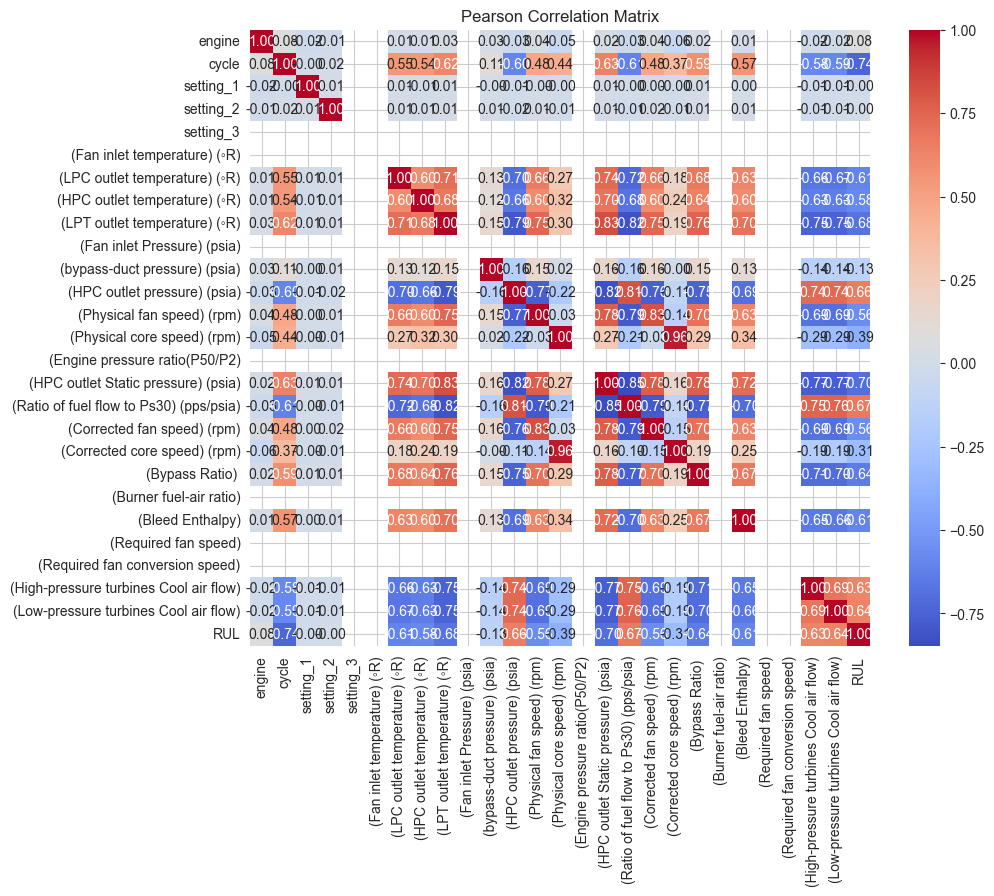

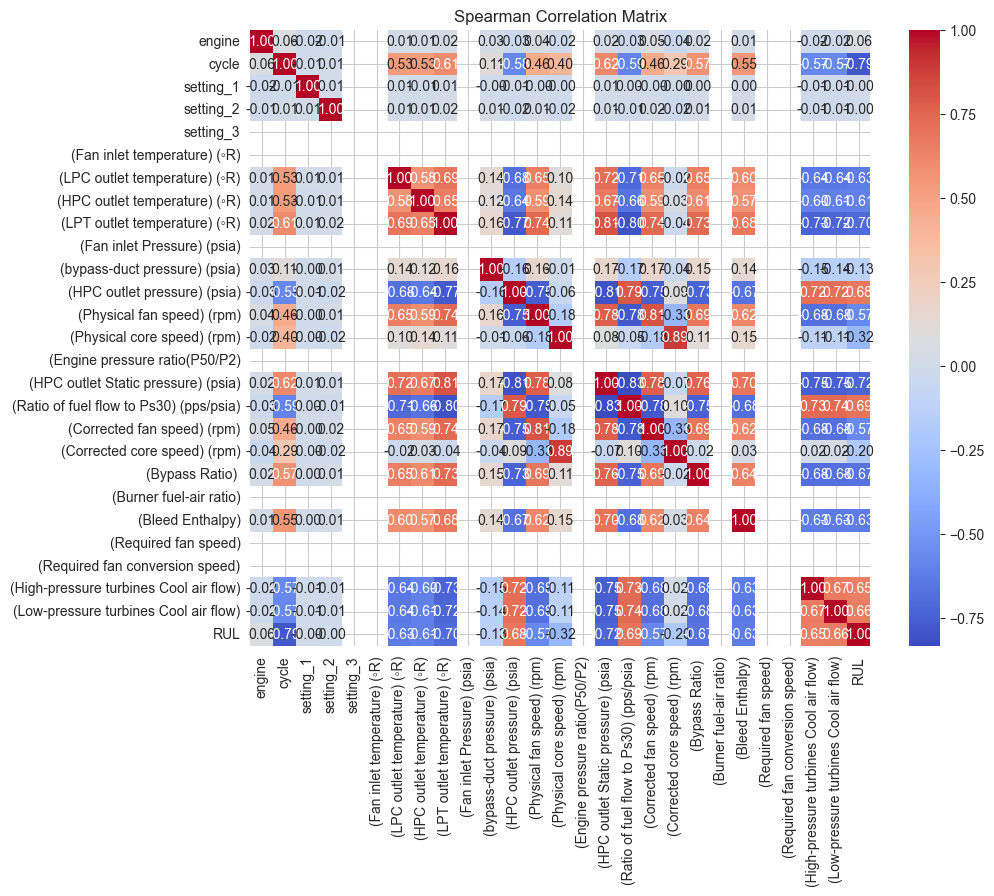

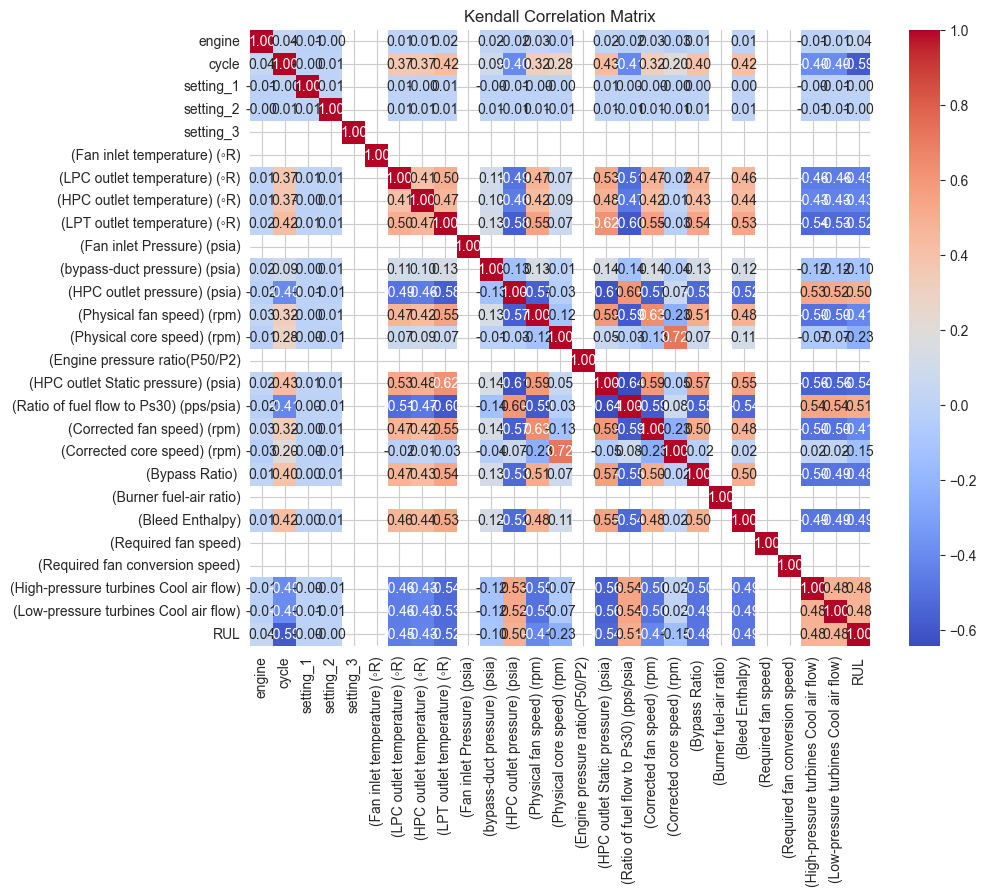

In [25]:
def plot_correlation_matrices(df):
    corr_methods = ['pearson', 'spearman', 'kendall']
    
    for method in corr_methods:
        corr_matrix = df.corr(method=method)
        plt.figure(figsize=(10, 8))
        sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
        plt.title(f'{method.capitalize()} Correlation Matrix')
        plt.show()

# Example usage
plot_correlation_matrices(df_train)


### Categorical data

In [26]:
# df = df_train.select_dtypes(include=['object'])
# 
# # Initialize the Dash app
# app = dash.Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])
# 
# # Dropdown options for categorical variables
# dropdown_options = [{'label': col, 'value': col} for col in df.select_dtypes(include=['object']).columns]
# 
# # Define the app layout
# app.layout = dbc.Container([
#     dbc.Row([
#         dbc.Col([
#             dcc.Dropdown(
#                 id='variable-dropdown',
#                 options=dropdown_options,
#                 value=df.select_dtypes(include=['object']).columns[0],
#                 clearable=False,
#                 className="mb-4"
#             )
#         ], width=12)
#     ]),
# 
#     dbc.Row([
#         dbc.Col([
#             html.H2("Text Variable Stats"),
#             html.Div(id='analysis-output', className="mb-4")
#         ], width=4),
# 
#         dbc.Col([
#             html.H2("Top 10 Words and Special Characters"),
#             html.Div(id='tables-output')
#         ], width=4),
# 
#         dbc.Col([
#             html.H2("Class Imbalance"),
#             html.Div(id='imbalance-output')
#         ], width=4)
#     ], style={'overflowY': 'scroll', 'maxHeight': '80vh'})
# ], fluid=True, style={'overflowY': 'scroll', 'maxHeight': '100vh'})
# 
# # Callback to update analysis, tables, and imbalance check based on selected variable
# @app.callback(
#     [Output('analysis-output', 'children'),
#      Output('tables-output', 'children'),
#      Output('imbalance-output', 'children')],
#     [Input('variable-dropdown', 'value')]
# )
# def update_output(selected_variable):
#     data = df[selected_variable]
# 
#     # Calculate analysis statistics
#     distinct_count_c = data.nunique()
#     counteruc = Counter(data)
#     unique_values_c = [item for item, count in counteruc.items() if count == 1]
#     unique_count_c = len(unique_values_c)
#     unique_percent_c = (len(unique_values_c) / len(data)) * 100
#     missing_count_c = int(data.isna().sum())
#     missing_percentage_c = (missing_count_c / len(data)) * 100
# 
#     len_mean = float(data.str.len().mean())
#     len_sd = float(data.str.len().std())
#     len_median = int(data.str.len().median())
#     len_min = int(data.str.len().min())
#     len_max = int(data.str.len().max())
#     sample_one = data.sample(frac=0.5, random_state=42, replace=True)
# 
#     def percentile_value(sample_one, percentile):
#         index = int((len(sample_one) - 1) * percentile)
#         return sample_one.iloc[index]
# 
#     percentile_1st = sample_one.iloc[0]
#     percentile_25th = percentile_value(sample_one, 0.25)
#     percentile_50th = percentile_value(sample_one, 0.5)
#     percentile_75th = percentile_value(sample_one, 0.75)
#     percentile_last = sample_one.iloc[-1]
# 
#     # Analysis output
#     analysis = html.Div([
#         html.P([html.Span("Distinct Count: ", style={'font-weight': 'normal'}), html.Span(f"{distinct_count_c}", style={'font-weight': 'bold'})]),
#         html.P([html.Span("Unique Count: ", style={'font-weight': 'normal'}), html.Span(f"{unique_count_c}", style={'font-weight': 'bold'})]),
#         html.P([html.Span("Unique %: ", style={'font-weight': 'normal'}), html.Span(f"{unique_percent_c:.2f}%", style={'font-weight': 'bold'})]),
#         html.P([html.Span("Missing Count: ", style={'font-weight': 'normal'}), html.Span(f"{missing_count_c}", style={'font-weight': 'bold'})]),
#         html.P([html.Span("Missing %: ", style={'font-weight': 'normal'}), html.Span(f"{missing_percentage_c:.2f}%", style={'font-weight': 'bold'})]),
#         html.P([html.Span("Mean Length: ", style={'font-weight': 'normal'}), html.Span(f"{len_mean:.2f}", style={'font-weight': 'bold'})]),
#         html.P([html.Span("Standard Deviation: ", style={'font-weight': 'normal'}), html.Span(f"{len_sd:.2f}", style={'font-weight': 'bold'})]),
#         html.P([html.Span("Median Length: ", style={'font-weight': 'normal'}), html.Span(f"{len_median}", style={'font-weight': 'bold'})]),
#         html.P([html.Span("Min Length: ", style={'font-weight': 'normal'}), html.Span(f"{len_min}", style={'font-weight': 'bold'})]),
#         html.P([html.Span("Max Length: ", style={'font-weight': 'normal'}), html.Span(f"{len_max}", style={'font-weight': 'bold'})]),
#         html.P([html.Span("1st Percentile: ", style={'font-weight': 'normal'}), html.Span(f"{percentile_1st}", style={'font-weight': 'bold'})]),
#         html.P([html.Span("25th Percentile: ", style={'font-weight': 'normal'}), html.Span(f"{percentile_25th}", style={'font-weight': 'bold'})]),
#         html.P([html.Span("50th Percentile: ", style={'font-weight': 'normal'}), html.Span(f"{percentile_50th}", style={'font-weight': 'bold'})]),
#         html.P([html.Span("75th Percentile: ", style={'font-weight': 'normal'}), html.Span(f"{percentile_75th}", style={'font-weight': 'bold'})]),
#         html.P([html.Span("Last Percentile: ", style={'font-weight': 'normal'}), html.Span(f"{percentile_last}", style={'font-weight': 'bold'})]),
#     ], className="mb-4")
# 
#     # Top 10 Words and Special Characters
#     top_10_df = pd.DataFrame(Counter(re.findall(r'\b\w+\b', ' '.join(data).lower())).most_common(10), columns=['Word', 'Frequency'])
#     special_char_df = pd.DataFrame(Counter(re.findall(r'[^\w\s]', ' '.join(data))).items(), columns=['Special Character', 'Frequency'])
# 
#     tables = html.Div([
#         html.H4("Top 10 Most Frequent Words"),dbc.Table.from_dataframe(top_10_df, striped=True, bordered=True, hover=True),
#         html.H4("Special Characters Frequency"),dbc.Table.from_dataframe(special_char_df, striped=True, bordered=True, hover=True) ], className="mb-4")
# 
#     # Class Imbalance Check
#     class_counts = df[selected_variable].value_counts()
#     majority_class_count = class_counts.max()
#     minority_class_count = class_counts.min()
#     imbalance_ratio = majority_class_count / minority_class_count
#     threshold = 2  # You can adjust this threshold as needed
#     is_imbalanced = imbalance_ratio > threshold
# 
#     imbalance_check = html.Div([
#         html.P([html.Span("Class Counts: ", style={'font-weight': 'normal'}), html.Span(f"{class_counts.to_dict()}", style={'font-weight': 'bold'})]),
#         html.P([html.Span("Imbalance Ratio: ", style={'font-weight': 'normal'}), html.Span(f"{imbalance_ratio:.2f}", style={'font-weight': 'bold'})]),
#         html.P([html.Span("Is the Data Imbalanced?: ", style={'font-weight': 'normal'}), html.Span(f"{'Yes' if is_imbalanced else 'No'}", style={'font-weight': 'bold'})]),
#     ], className="mb-4")
# 
#     return analysis, tables, imbalance_check
# 
# # Run the app
# if __name__ == '__main__':
#     app.run_server(debug=True)


### Cleaning

In [27]:
df_train_RUL = df_train.groupby(['engine']).agg({'cycle':'max'})
df_train_RUL.rename(columns={'cycle':'life'},inplace=True)
df_train_RUL.head()

,life
engine,
1,192
2,287
3,179
4,189
5,269


In [28]:
df_train = df_train.merge(df_train_RUL,on='engine',how='left')

In [29]:
df_train['RUL']=df_train['life']-df_train['cycle']
df_train.drop(['life'],axis=1,inplace=True)
df_train.to_csv("/Users/aswathshakthi/PycharmProjects/MLOps/Predictive_maintenance/data/processed/df_train.csv",index=False)
df_train

,engine,cycle,setting_1,setting_2,setting_3,(Fan inlet temperature) (◦R),(LPC outlet temperature) (◦R),(HPC outlet temperature) (◦R),(LPT outlet temperature) (◦R),(Fan inlet Pressure) (psia),...,(Corrected fan speed) (rpm),(Corrected core speed) (rpm),(Bypass Ratio),(Burner fuel-air ratio),(Bleed Enthalpy),(Required fan speed),(Required fan conversion speed),(High-pressure turbines Cool air flow),(Low-pressure turbines Cool air flow),RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735,4
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594,3
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333,2
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640,1


In [30]:
df_test_RUL.columns = ['RUL']
df_test_RUL['engine'] = range(1, len(df_test_RUL) + 1)
df_test = df_test.merge(df_test_RUL,on='engine',how='left')
df_test.to_csv("/Users/aswathshakthi/PycharmProjects/MLOps/Predictive_maintenance/data/processed/df_test.csv",index=False)
df_test

ValueError: Length mismatch: Expected axis has 2 elements, new values have 1 elements

In [31]:
# Assume df_train and df_test are already loaded DataFrames with 'RUL' as the target variable
X_train = df_train.drop(columns=['RUL'])
y_train = df_train['RUL']
X_test = df_test.drop(columns=['RUL'])
y_test = df_test['RUL']

### Feature Engineering
	1.	Polynomial features
	2.	Interaction features
	3.	Log transformation
	4.	Scaling and normalization
	5.	Binning
	6.	Encoding categorical variables
    7. Dimensionality Reduction 

##### 1. Polynomial Features

In [32]:
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Convert to DataFrame for easier handling
X_train_poly = pd.DataFrame(X_train_poly, columns=poly.get_feature_names_out(X_train.columns))
X_test_poly = pd.DataFrame(X_test_poly, columns=poly.get_feature_names_out(X_test.columns))


##### 2. Interaction Features
Interaction features are already included in polynomial features of degree 2.

##### 3. Log Transformation

In [33]:
# Apply log transformation to all numerical features (assuming all features are numerical for simplicity)
X_train_log = np.log1p(X_train)
X_test_log = np.log1p(X_test)


##### 4. Scaling and Normalisation

In [34]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)


##### 5. Binning

In [35]:
# # Apply binning to a numerical feature (example: 'feature1')
# binning = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
# X_train_binned = binning.fit_transform(X_train[['feature1']])
# X_test_binned = binning.transform(X_test[['feature1']])
# 
# # Add binned feature back to the DataFrame
# X_train['feature1_binned'] = X_train_binned
# X_test['feature1_binned'] = X_test_binned


##### 6. Encoding Categorical Variables

In [36]:
# # Example: Encoding a categorical feature 'category_feature'
# encoder = OneHotEncoder(sparse_output=False)
# X_train_encoded = encoder.fit_transform(X_train[['category_feature']])
# X_test_encoded = encoder.transform(X_test[['category_feature']])
# 
# # Add encoded features back to the DataFrame
# X_train_encoded = pd.DataFrame(X_train_encoded, columns=encoder.get_feature_names_out(['category_feature']))
# X_test_encoded = pd.DataFrame(X_test_encoded, columns=encoder.get_feature_names_out(['category_feature']))
# 
# X_train = X_train.join(X_train_encoded).drop(columns=['category_feature'])
# X_test = X_test.join(X_test_encoded).drop(columns=['category_feature'])


##### 7. Dimensionality Reduction

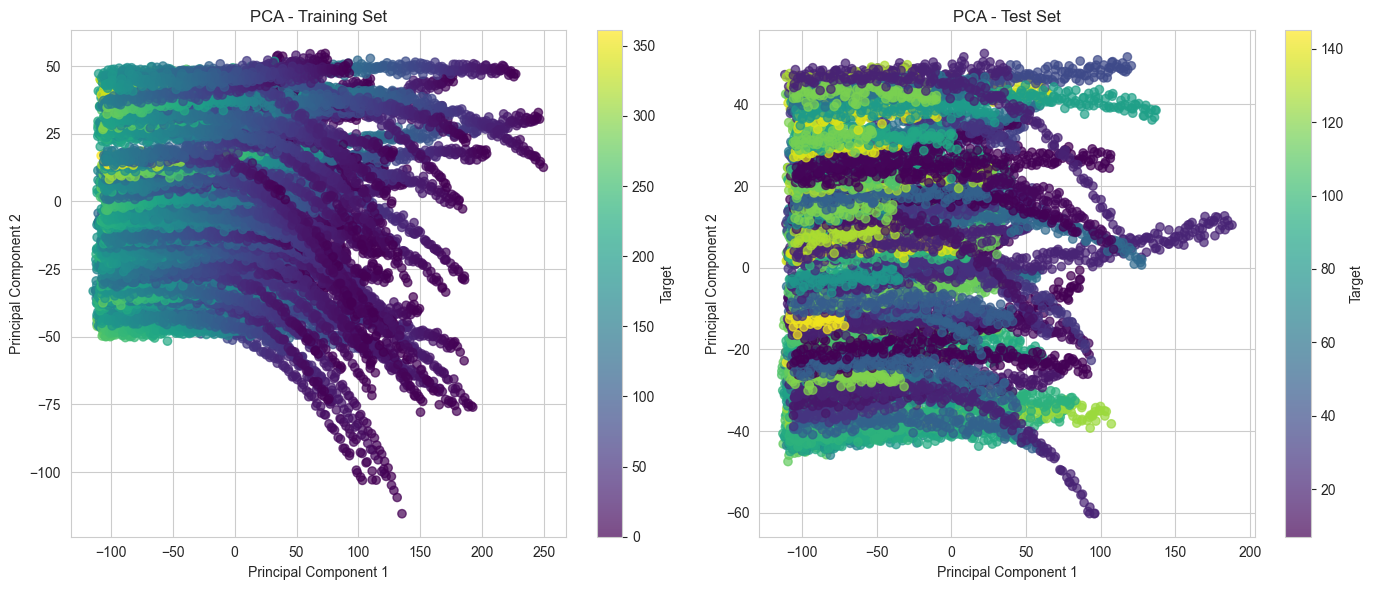

In [37]:
pca = PCA(n_components=5)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Convert to DataFrame for easier handling
X_train_pca = pd.DataFrame(X_train_pca, columns=[f'PC{i+1}' for i in range(X_train_pca.shape[1])])
X_test_pca = pd.DataFrame(X_test_pca, columns=[f'PC{i+1}' for i in range(X_test_pca.shape[1])])

# Plotting the first two principal components for the training set
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(X_train_pca['PC1'], X_train_pca['PC2'], c=y_train, cmap='viridis', alpha=0.7)
plt.title("PCA - Training Set")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label='Target')

# Plotting the first two principal components for the test set
plt.subplot(1, 2, 2)
plt.scatter(X_test_pca['PC1'], X_test_pca['PC2'], c=y_test, cmap='viridis', alpha=0.7)
plt.title("PCA - Test Set")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label='Target')

plt.tight_layout()
plt.show()



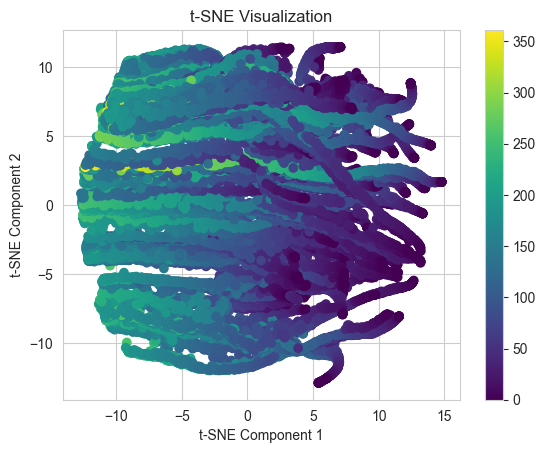

In [38]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Assume X_train contains the high-dimensional data
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
X_train_tsne = tsne.fit_transform(X_train)

# Plotting
plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=y_train, cmap='viridis')
plt.title("t-SNE Visualization")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.colorbar()
plt.show()


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


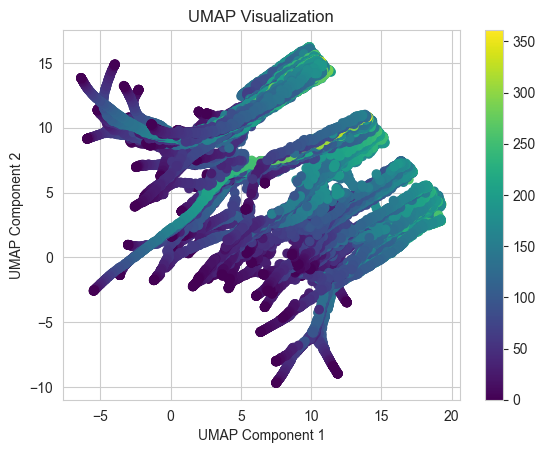

In [39]:
import umap
import umap.umap_ as umap
import matplotlib.pyplot as plt

# Assume X_train contains the high-dimensional data
# UMAP parameters: n_neighbors (local structure), min_dist (spread of points)
umap_reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2)
X_train_umap = umap_reducer.fit_transform(X_train)

# Plotting the UMAP results
plt.scatter(X_train_umap[:, 0], X_train_umap[:, 1], c=y_train, cmap='viridis')
plt.title("UMAP Visualization")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.colorbar()
plt.show()


### Feature Selection
1. Filter Method ( eg. Correlatiom matrix, VIF(multicolinerity)
2. Wrapper method (eg. Recursive feature elimination)
 3. Embedded methods (eg. Lasso regression)

###### 1.  Filter Method (Correlation Matrix and VIF)

In [ ]:
# Correlation matrix
corr_matrix = X_train.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.8
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]
X_train_filtered = X_train.drop(columns=to_drop)
X_test_filtered = X_test.drop(columns=to_drop)

# VIF
def calculate_vif(df):
    vif = pd.DataFrame()
    vif["features"] = df.columns
    vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif

vif_df = calculate_vif(X_train_filtered)
# Drop features with high VIF
X_train_vif = X_train_filtered.drop(columns=vif_df[vif_df['VIF'] > 10]['features'])
X_test_vif = X_test_filtered.drop(columns=vif_df[vif_df['VIF'] > 10]['features'])


##### 2. Wrapper Method (Recursive Feature Elimination)

In [ ]:
model = RandomForestRegressor()
rfe = RFE(model, n_features_to_select=5)
X_train_rfe = rfe.fit_transform(X_train, y_train)
X_test_rfe = rfe.transform(X_test)

# Get the selected feature names
selected_features = X_train.columns[rfe.support_]


##### 3. Embedded Methods (Lasso Regression)

In [ ]:
lasso = Lasso(alpha=0.01)
lasso.fit(X_train, y_train)

# Get the coefficients
lasso_coef = pd.Series(lasso.coef_, index=X_train.columns)

# Select features with non-zero coefficients
selected_features_lasso = lasso_coef[lasso_coef != 0].index
X_train_lasso = X_train[selected_features_lasso]
X_test_lasso = X_test[selected_features_lasso]


### Feature Importance
    1.Tree-based methods (e.g., Random Forest, XGBoost)
    2.Permutation importance
    3.SHAP (SHapley Additive exPlanations)Shap

##### 1. Tree-based Methods (Random Forest, XGBoost)

In [ ]:
# Random Forest
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
rf_importances = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# XGBoost
import xgboost as xgb
xgb_model = xgb.XGBRegressor()
xgb_model.fit(X_train, y_train)
xgb_importances = pd.Series(xgb_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)


##### 2. Permutation Importance

In [ ]:
perm_importance = permutation_importance(rf, X_test, y_test)
perm_importances = pd.Series(perm_importance.importances_mean, index=X_test.columns).sort_values(ascending=False)

##### 3. SHAP(SHapley Additive exPlanations)

In [ ]:
explainer = shap.Explainer(rf, X_train)
shap_values = explainer(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test)